# Vision | Domain-Adversarial Training of Neural Networks

By [Akshaj Verma](https://akshajverma.com)

This notebook takes you through the implementation of the paper - [*Unsupervised Domain Adaptation by Backpropagation*](https://arxiv.org/pdf/1409.7495.pdf) by *[Yaroslav Ganin](http://yaroslav.ganin.net/#) et. al.* using PyTorch.

First we'll train the a model on source dataset => MNIST. Then we'll compare it's performance on the target => MNISTM. Then we'll train another model using domain adaptation and test it again on MNISTM. 

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt



import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split


from sklearn.metrics import classification_report, confusion_matrix

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

## Define Paths and Set GPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

root_dir = "../../../data/computer_vision/domain_adaptation/Mnist2MnistM/"
print("The data lies here =>", root_dir)

We're using => cuda
The data lies here => ../../../data/computer_vision/domain_adaptation/Mnist2MnistM/


In [5]:
os.listdir(root_dir)

['mnistM', 'mnist']

## Load MNIST and MNIST-M Data

In [6]:
mnist_dir = root_dir + "mnist/"
mnist_m_dir = root_dir + "mnistM/"

### Convert Images to Tensor

In [46]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    "test": transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}

### Create Dataset

In [47]:
# mnist
mnist_dataset_train = datasets.ImageFolder(root = mnist_dir + "train",
                                           transform = image_transforms["train"]
                                          )

mnist_dataset_test = datasets.ImageFolder(root = mnist_dir + "test",
                                           transform = image_transforms["test"]
                                          )


# mnistM
mnist_m_dataset_train = datasets.ImageFolder(root = mnist_m_dir + "train",
                                             transform = image_transforms["train"]
                                            )

mnist_m_dataset_test = datasets.ImageFolder(root = mnist_m_dir + "test",
                                            transform = image_transforms["test"]
                                           )

### Create Dataloader

In [48]:
BATCH_SIZE = 32

# mnist
mnist_loader_train = torch.utils.data.DataLoader(mnist_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
mnist_loader_test = torch.utils.data.DataLoader(mnist_dataset_test, batch_size=1, shuffle=False)

# mnistM
mnist_m_loader_train = torch.utils.data.DataLoader(mnist_m_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
mnist_m_loader_test = torch.utils.data.DataLoader(mnist_m_dataset_test, batch_size=1, shuffle=False)

### Explore Data

#### MNIST

In [49]:
single_batch = next(iter(mnist_loader_train))
images, labels = single_batch

print("Input images (batch, channels, height, width): ", images.size())
print("Output labels: ", labels.size())

Input images (batch, channels, height, width):  torch.Size([32, 3, 28, 28])
Output labels:  torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


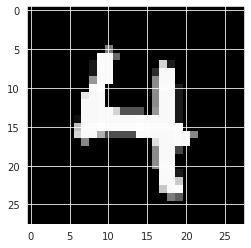

In [50]:
plt.imshow(images[0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


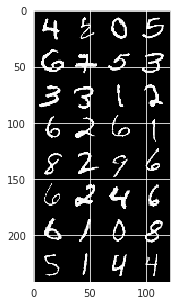

In [51]:
single_image = single_batch[0][0]
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,5))
plt.imshow(single_batch_grid.permute(1, 2, 0))

#### MNIST-M

In [52]:
single_batch = next(iter(mnist_m_loader_train))
images, labels = single_batch

print("Input images (batch, channels, height, width): ", images.size())
print("Output labels: ", labels.size())

Input images (batch, channels, height, width):  torch.Size([32, 3, 28, 28])
Output labels:  torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


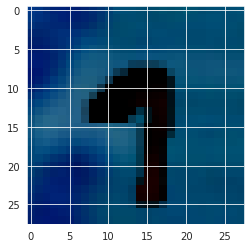

In [53]:
plt.imshow(images[0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


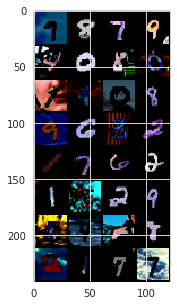

In [54]:
single_image = single_batch[0][0]
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,5))
plt.imshow(single_batch_grid.permute(1, 2, 0))

## TRAIN on MNIST [Source]

### Model Definition

In [16]:
class ModelMnistSource(nn.Module):
    def __init__(self, num_classes=10):
        super(ModelMnistSource, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.1)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2)
        )
        
        self.fc = nn.Linear(32*28*28, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

### Initialize Model

In [17]:
model_mnist = ModelMnistSource()
print(f"We're using {device}.\n")
model_mnist.to(device)
print(model_mnist)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mnist.parameters(), lr=0.001)

We're using cuda.

ModelMnistSource(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (fc): Linear(in_features=25088, out_features=10, bias=True)
)


In [18]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

### Train Loop

In [19]:
EPOCHS = 3

for e in tqdm(range(1, EPOCHS + 1)):
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model_mnist.train()
    for X_train_batch, y_train_batch in mnist_loader_train:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model_mnist(X_train_batch).squeeze()
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(mnist_loader_train):.5f} | Train Acc: {train_epoch_acc/len(mnist_loader_train):.3f}')

Epoch 001: | Train Loss: 0.22722 | Train Acc: 99.520
Epoch 002: | Train Loss: 0.07171 | Train Acc: 100.000
Epoch 003: | Train Loss: 0.05512 | Train Acc: 100.000



## Test on MNIST [Source]

In [20]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    model_mnist.eval()
    for x_batch, y_batch in tqdm(mnist_loader_test):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model_mnist(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
        

y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [21]:
print("Trained on MNIST | Tested on MNIST. \n\n")
print(classification_report(y_true_list, y_pred_list))

Trained on MNIST | Tested on MNIST. 


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.98      0.99      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       1.00      0.98      0.99       958
           7       0.99      0.97      0.98      1028
           8       0.97      0.99      0.98       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## Test on MNIST-M [Target]

Now, let's test our model on the target dataset, ie. MNIST-M.

To do that, we need to load the data first.

In [22]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    model_mnist.eval()
    for x_batch, y_batch in tqdm(mnist_m_loader_test):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model_mnist(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
        
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [23]:
print("Trained on MNIST | Tested on MNIST-M. \n\n")
print(classification_report(y_true_list, y_pred_list))

Trained on MNIST | Tested on MNIST-M. 


              precision    recall  f1-score   support

           0       0.98      0.30      0.46       878
           1       0.99      0.23      0.37      1016
           2       0.41      0.44      0.43       933
           3       0.45      0.54      0.49       908
           4       0.97      0.26      0.41       890
           5       0.55      0.44      0.49       807
           6       0.30      0.67      0.41       856
           7       0.85      0.35      0.50       914
           8       0.90      0.24      0.38       880
           9       0.24      0.78      0.37       919

    accuracy                           0.42      9001
   macro avg       0.66      0.43      0.43      9001
weighted avg       0.67      0.42      0.43      9001



**As we see from the results above, our model trained on MNIST performs horribly for MNIST-M.**

> Let's see some of that unsupervised domain adaption now.

## Train DANN Model [using MNIST and MNIST-M]

In a DANN, we use both MNIST and MNIST-M ie. source and target to train our model.

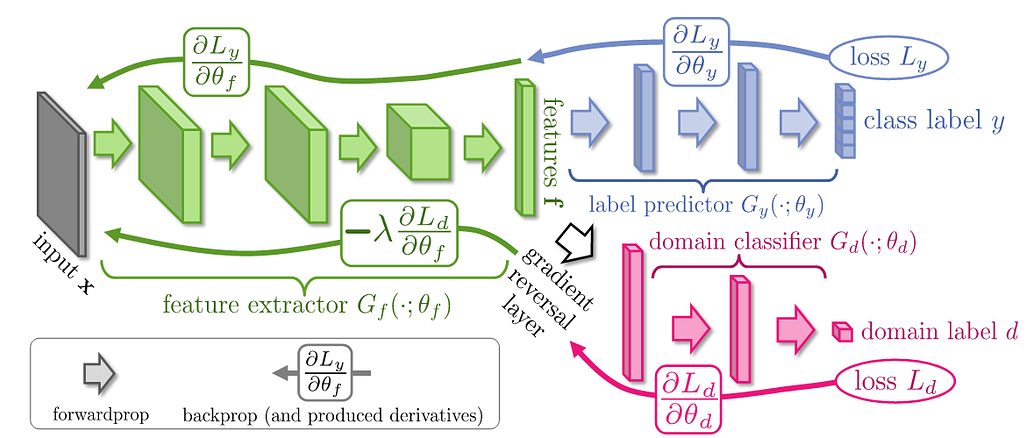

### Gradient Reverse Layer

Before we define the model architecture, we need to implement the **Gradient Reverse Layer**. Check out => [PyTorch: Defining New autograd Functions](https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html)

In [37]:
class GRL(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input_val, alpha):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. 
        """
        
        ctx.alpha = alpha
        
        # No operation during the forward pass.
        return input_val

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        
        # Multiply the the gradient output by -1.
        output_val = -ctx.alpha * grad_output
        
        return output_val, None

Before we proceed further, let's see the GRL in action. We'll use the same input tensors and compare the effect of our `GRL`.

#### Autograd without GRL

In [38]:
x1 = torch.tensor(1., requires_grad = True)
x2 = torch.tensor(2., requires_grad = True)
x3 = torch.tensor(3., requires_grad = True)
x4 = torch.tensor(4., requires_grad = True)

z1 = x1 * x2 
z2 = x3 * x4
f = z1 + z2

print("f: ", f)

f.backward(retain_graph=True)

print(f"Gradient of x1 = {x1.grad}")
print(f"Gradient of x2 = {x2.grad}")
print(f"Gradient of x3 = {x3.grad}")
print(f"Gradient of x4 = {x4.grad}")

f:  tensor(14., grad_fn=<AddBackward0>)
Gradient of x1 = 2.0
Gradient of x2 = 1.0
Gradient of x3 = 4.0
Gradient of x4 = 3.0


#### Autograd with GRL

In [39]:
x5 = torch.tensor(1., requires_grad = True)
x6 = torch.tensor(2., requires_grad = True)
x7 = torch.tensor(3., requires_grad = True)
x8 = torch.tensor(4., requires_grad = True)

z3 = x5 * x6 
z4 = x7 * x8
g = z3 + z4

g = GRL.apply(g, 1)

print("g: ", g)

g.backward(retain_graph=True)

print(f"Gradient of x5 = {x5.grad}")
print(f"Gradient of x6 = {x6.grad}")
print(f"Gradient of x7 = {x7.grad}")
print(f"Gradient of x8 = {x8.grad}")

g:  tensor(14., grad_fn=<GRLBackward>)
Gradient of x5 = -2.0
Gradient of x6 = -1.0
Gradient of x7 = -4.0
Gradient of x8 = -3.0


As we can see, all the gradients have been multiplied `-1` in the second case.

Let's move on to defining our model.

### Model Definitions

In [55]:
class ModelDANN(nn.Module):
    def __init__(self):
        super(ModelDANN, self).__init__()
                
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
                        
            nn.Flatten(),
            nn.ReLU()
        )
        
        self.class_predictor = nn.Sequential(
            nn.Linear(49 * 48, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        
        self.domain_predictor = nn.Sequential(
            nn.Linear(49 * 48, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )
        
        
    def forward(self, input_image, adaptation_factor=1):
        image_features = self.feature_extractor(input_image)
        
        image_features_grl = GRL.apply(image_features, adaptation_factor)
        
        pred_class_labels = self.class_predictor(image_features)
        pred_domain_labels = self.domain_predictor(image_features_grl)
        
        return pred_class_labels, pred_domain_labels

In [56]:
model_dann = ModelDANN()

model_dann.to(device)

print(model_dann)

criterion_for_class = nn.CrossEntropyLoss()
criterion_for_domain = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_dann.parameters(), lr=0.001)

ModelDANN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten()
    (7): ReLU()
  )
  (class_predictor): Sequential(
    (0): Linear(in_features=2352, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
  (domain_predictor): Sequential(
    (0): Linear(in_features=2352, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=2, bias=True)
  )
)


### Model Output Example

In [57]:
x_source_example, y_source_example = next(iter(mnist_loader_train))
x_target_example, y_target_example = next(iter(mnist_m_loader_train))

In [58]:
print("Source input shapes: ", "\n\tX - ", x_source_example.shape, "\n\ty - ",y_source_example.shape)
print("Target input shapes: ", "\n\tX - ", x_target_example.shape, "\n\ty - ",y_target_example.shape)

Source input shapes:  
	X -  torch.Size([32, 3, 28, 28]) 
	y -  torch.Size([32])
Target input shapes:  
	X -  torch.Size([32, 3, 28, 28]) 
	y -  torch.Size([32])


In [59]:
class_example, domain_example = model_dann(x_source_example.to(device), 1.0)
print("Shape of class predictor: ", class_example.shape)
print("Shape of domain predictor: ", domain_example.shape)

Shape of class predictor:  torch.Size([32, 10])
Shape of domain predictor:  torch.Size([32, 2])


### Training Loop

#### The Problem of Number of Batches

We need to do one last thing before we start training. The two datasets (source and target) might have different sizes and as a result, different number of batches. We need to obtain the minimum of the two _number of batches_ between the source and target dataloaders.

In [60]:
MAX_BATCH_NUM = min(len(mnist_loader_train), len(mnist_m_loader_train)) - 1
MAX_BATCH_NUM

1843

Since, everything is working as expected, let's proceed to writing the training loop.

In [61]:
EPOCHS = 10

model_dann.train()

for e in tqdm(range(1, EPOCHS+1)):
    train_dataloader_source = iter(mnist_loader_train)
    train_dataloader_target = iter(mnist_m_loader_train)
    
    epoch_loss = 0
    
    for b in range(MAX_BATCH_NUM):
        
        # training_progress
        p = np.float(b + e * MAX_BATCH_NUM) / np.float(EPOCHS * MAX_BATCH_NUM)
        lambda_grl = 2. / (1. + np.exp(-10 * p)) - 1
        
        
        x_batch_source, y_batch_source = next(train_dataloader_source)
        x_batch_target, _ = next(train_dataloader_target)
        
        x_batch_source, y_batch_source = x_batch_source.to(device), y_batch_source.to(device)
        x_batch_target = x_batch_target.to(device)
        
        
        optimizer.zero_grad()
        
        # source
        y_domain_source = torch.zeros(BATCH_SIZE, dtype=torch.long).to(device)
        y_pred_class_source, y_pred_domain_source = model_dann(x_batch_source, lambda_grl)
        
        loss_class_source = criterion_for_class(y_pred_class_source, y_batch_source)
        loss_domain_source = criterion_for_domain(y_pred_domain_source, y_domain_source)
        
        
        # target
        y_domain_target = torch.ones(BATCH_SIZE, dtype=torch.long).to(device)
        _, y_pred_domain_target = model_dann(x_batch_target, 1)
        
        loss_domain_target = criterion_for_domain(y_pred_domain_target, y_domain_target)
        
        
        total_loss = loss_class_source + loss_domain_source + loss_domain_target
        
        total_loss.backward()
        optimizer.step()
        
        epoch_loss += total_loss.item()
        
    print(e, " | ", epoch_loss/MAX_BATCH_NUM)

1  |  1.2728906030313385
2  |  0.9415529850330678
3  |  0.7251835626894149
4  |  0.8842681234564007
5  |  0.9687844644938871
6  |  1.039191194286957
7  |  0.9789472452920219
8  |  1.1127253191275759
9  |  1.1576461286824227
10  |  1.170045231857574



## Test DANN Model on Target [MNIST-M]

In [ ]:
y_pred_class_list = []
y_true_class_list = []

with torch.no_grad():
    test_dataloader_target = iter(mnist_m_loader_test)
    
    epoch_loss = 0
    
    for x_batch, y_batch in tqdm(mnist_m_loader_test):
        model_dann.eval()        
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        class_pred, _ = model_dann(x_batch)
        class_pred_logsoftmax = torch.log_softmax(class_pred, dim = 1)
        
        _, class_pred_value = torch.max(class_pred_logsoftmax, dim = 1)
        
        y_true_class_list.append(y_batch.item())
        y_pred_class_list.append(class_pred_value.item())     
    

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_class_list, y_pred_class_list)) #.rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
print(classification_report(y_true_class_list, y_pred_class_list))